In [34]:
import numpy as np
from scipy.stats import pearsonr   
from utils import create_loaders, compute_distance, MAPE
from australian_data_utils import get_australian_data, create_model_loader_train_objects

import torch
import torch.nn as nn

import matplotlib.pyplot as plt

import copy
np.random.seed(0)
torch.manual_seed(42)

In [2]:
train_window = 36
horizon = 12

input_dimension = 1
hidden_dimension = 40
batch_size = 256

support_train_loader_dictionary = {}
support_validation_loader_dictionary = {}
support_train_object_dictionary = {}

query_train_loader_dictionary = {}
query_validation_loader_dictionary = {}
query_train_object_dictionary = {}


In [3]:
meta_query_austalian_data = [('NSW', '03'), ('NSW', '18'), ('QLD', '03'), ('QLD', '18'), ('SA', '03')]
meta_support_austalian_data = [('SA', '18'), ('TAS', '07'), ('TAS', '18'), ('VIC', '04'), ('VIC', '18')]


In [4]:
create_model_loader_train_objects(data=meta_support_austalian_data,
                                  train_loader_dictionary=support_train_loader_dictionary, 
                                  validation_loader_dictionary=support_validation_loader_dictionary,
                                  train_object_dictionary=support_train_object_dictionary,
                                  train_window=train_window, hidden_dimension=hidden_dimension, horizon=horizon, batch_size=batch_size,
                                  train_model=True, num_epochs=50)

1- creating objects from SA on year 18
-----starting training-----
epoch 10 train loss 0.00500 ------ validation loss 0.00468
epoch 20 train loss 0.00433 ------ validation loss 0.00390
epoch 30 train loss 0.00307 ------ validation loss 0.00457
epoch 40 train loss 0.00359 ------ validation loss 0.00351
epoch 50 train loss 0.00394 ------ validation loss 0.00361
epoch 50 train loss 0.00394 ------ validation loss 0.00361
2- creating objects from TAS on year 07
-----starting training-----
epoch 10 train loss 0.00333 ------ validation loss 0.00381
epoch 20 train loss 0.00319 ------ validation loss 0.00336
epoch 30 train loss 0.00290 ------ validation loss 0.00291
epoch 40 train loss 0.00352 ------ validation loss 0.00287
epoch 50 train loss 0.00322 ------ validation loss 0.00285
epoch 50 train loss 0.00322 ------ validation loss 0.00285
3- creating objects from TAS on year 18
-----starting training-----
epoch 10 train loss 0.00444 ------ validation loss 0.00476
epoch 20 train loss 0.00533 --

In [5]:
create_model_loader_train_objects(data=meta_query_austalian_data,
                                  train_loader_dictionary=query_train_loader_dictionary, 
                                  validation_loader_dictionary=query_validation_loader_dictionary,
                                  train_object_dictionary=query_train_object_dictionary,
                                  train_window=train_window, hidden_dimension=hidden_dimension, horizon=horizon, batch_size=batch_size,
                                  train_model=False)

1- creating objects from NSW on year 03
2- creating objects from NSW on year 18
3- creating objects from QLD on year 03
4- creating objects from QLD on year 18
5- creating objects from SA on year 03


In [6]:
# experiment_iteration_result = []
iteration_number = 10
for _ in range(iteration_number):
    distance_list = []
    for key, item in support_train_object_dictionary.items():
        distance_list.append(compute_distance(item.model, item.train_loader, query_train_object_dictionary['train_objectQLD18'].train_loader, batch_size, batch_size))
        
    test_object_dictionary = {}
    for i, (k, v) in enumerate(support_train_object_dictionary.items()):
        test_object_dictionary[f'obejct{i+1}'] = copy.deepcopy(query_train_object_dictionary['train_objectQLD18'])
        test_object_dictionary[f'obejct{i+1}'].model = v.model
        test_object_dictionary[f'obejct{i+1}'].train(num_epochs=3, verbose=False)
            
    mape_list = []
    mseloss_list = []
    for i, (k, v) in enumerate(support_train_object_dictionary.items()):

        inputs, target = next(enumerate(test_object_dictionary[f'obejct{i+1}'].train_loader, 0))[1]
        inputs = inputs.type(torch.float32).to(test_object_dictionary[f'obejct{i+1}'].learning_parmeters['device'])
        target = target.type(torch.float32).to(test_object_dictionary[f'obejct{i+1}'].learning_parmeters['device'])
        outputs = test_object_dictionary[f'obejct{i+1}'].model(inputs)
        with torch.no_grad():
            mseloss_list.append(nn.MSELoss()(target, outputs).item())
            mape_list.append(MAPE(target, outputs)[MAPE(target, outputs)<9999].mean().item())


    experiment_iteration_result.append([distance_list, mape_list, mseloss_list])

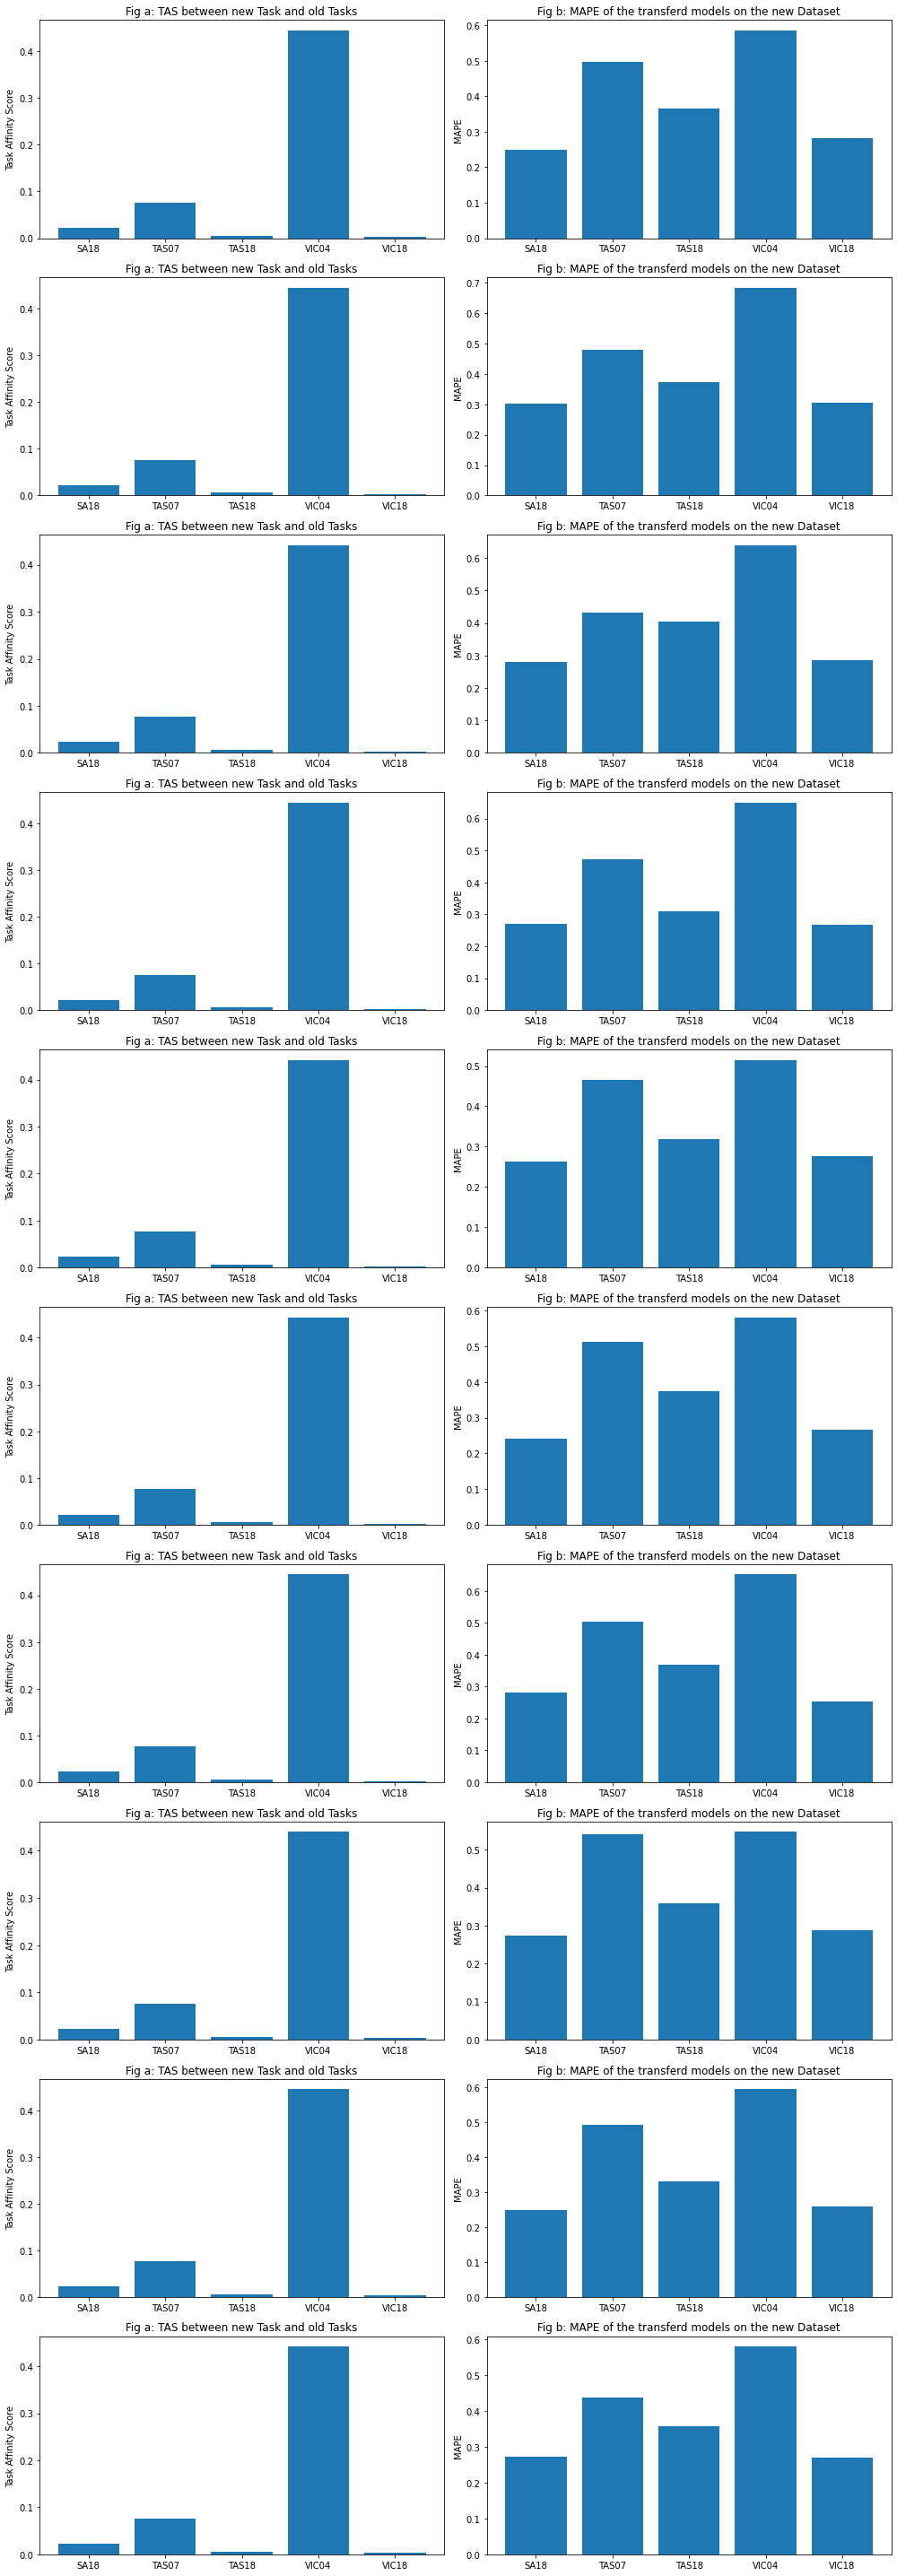

In [57]:
fig, axes = plt.subplots(10, 2,  figsize=(14, 40))
for i in range(10):
    xlabel = [i+j for i, j in meta_support_austalian_data]
    axes[i, 0].bar(xlabel, experiment_iteration_result[i][0])
    axes[i, 0].set_ylabel('Task Affinity Score')
    axes[i, 0].set_title('Fig a: TAS between new Task and old Tasks')

    axes[i, 1].bar(xlabel, experiment_iteration_result[i][1])
    axes[i, 1].set_ylabel('MAPE')
    axes[i, 1].set_title('Fig b: MAPE of the transferd models on the new Dataset')

plt.tight_layout()
plt.show()

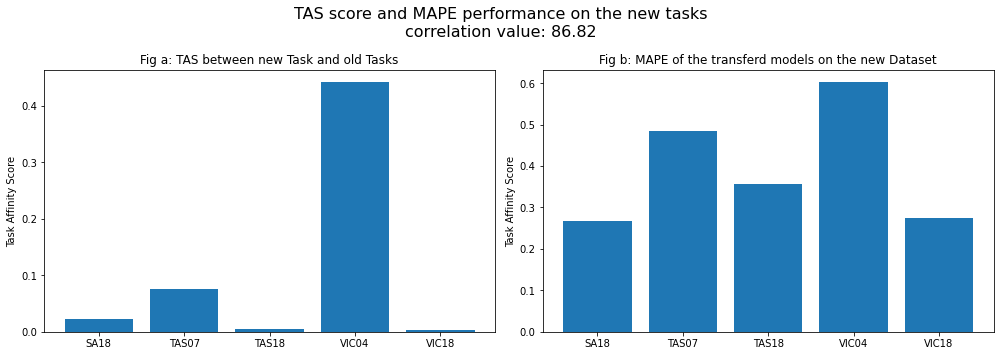

In [44]:
fig, axes = plt.subplots(1, 2,  figsize=(14, 5))
fig.suptitle(f"TAS score and MAPE performance on the new tasks\ncorrelation value: {pearsonr(np.array(experiment_iteration_result)[:,1,:].mean(axis=0), distance_list)[0]*100:.2f}", fontsize=16)

xlabel = [i+j for i, j in meta_support_austalian_data]

axes[0].bar(xlabel, experiment_iteration_result[i][0])
axes[0].set_ylabel('Task Affinity Score')
axes[0].set_title('Fig a: TAS between new Task and old Tasks')

axes[1].bar(xlabel, np.array(experiment_iteration_result)[:,1,:].mean(axis=0))
axes[1].set_ylabel('Task Affinity Score')
axes[1].set_title('Fig b: MAPE of the transferd models on the new Dataset')

plt.tight_layout()
plt.show()